# Sarcasm Detection: Deep NLP Models

## Download Dataset

In [1]:
# Download Dataset

!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -O /tmp/sarcasm.json

--2022-09-07 18:32:14--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2022-09-07 18:32:15 (202 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



## Read Dataset

In [2]:
import pandas as pd


# Read dataset
df = pd.read_json("/tmp/sarcasm.json")

In [5]:
# Check column titles
print(df.columns)
print('-'*30)
# Check number of samples for each class
print(df['is_sarcastic'].value_counts())

Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')
------------------------------
0    14985
1    11724
Name: is_sarcastic, dtype: int64


## Create input lists

In [8]:
# Convert columns to lists
sentences = df['headline'].to_list()
labels = df['is_sarcastic'].to_list()

print('Total number of samples:', len(sentences))

Total number of samples: 26709


## Preprocessing

In [31]:
vocab_size = 13200
embedding_dim = 50
max_len = 50

In [33]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
sw = stopwords.words('english')

for i in range(len(sentences)):
    words = sentences[i].split()
    # List Comprehension
    words2 = [w for w in words if w not in sw]
    sentences[i] = ' '.join(words2)

# Split data into train/valid
TRAIN_SIZE = 20000
train_sentences = sentences[0:TRAIN_SIZE]
valid_sentences = sentences[TRAIN_SIZE:]

train_labels = labels[0:TRAIN_SIZE]
valid_labels = labels[TRAIN_SIZE:]

# Tokenization
tokenizer = Tokenizer(oov_token='<oov>', num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
# print(word_index)
print('Number of words =', len(word_index))

# Sequencing
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
# print(train_sequences[0])

# Padding
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_len)
valid_padded = pad_sequences(valid_sequences, padding='post', maxlen=max_len)
print('Train data shape:', train_padded.shape)
print('Validation data shape:', valid_padded.shape)

# Need this block to get it to work with TensorFlow 2.x
train_padded = np.array(train_padded)
valid_padded = np.array(valid_padded)
train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of words = 25565
Train data shape: (20000, 50)
Validation data shape: (6709, 50)


## Create and Train Model

### Create some test models

In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [14]:
# Simple MLP model
model1 = Sequential([
                    layers.Dense(100, activation='relu',
                                 input_shape=[train_padded.shape[1],]),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1, activation='sigmoid')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 32)                3232      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,365
Trainable params: 6,365
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Adding Embedding layer
model2 = Sequential([
                     layers.Embedding(input_dim=vocab_size,
                                      output_dim=embedding_dim,
                                      input_length=max_len),
                     layers.GlobalAveragePooling1D(),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(8, activation='relu'),
                     layers.Dense(1, activation='sigmoid')                  
])

model2.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 50)            660000    
                                                                 
 global_average_pooling1d_2   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_15 (Dense)            (None, 32)                1632      
                                                                 
 dense_16 (Dense)            (None, 8)                 264       
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 661,905
Trainable params: 661,905
Non-trainable params: 0
________________________________________________

In [35]:
# Adding Conv1D layer
model3 = Sequential([
                     layers.Embedding(input_dim=vocab_size,
                                      output_dim=embedding_dim,
                                      input_length=max_len),
                     layers.Conv1D(8, 5, activation='relu', padding='same'),
                     layers.GlobalAveragePooling1D(),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(8, activation='relu'),
                     layers.Dense(1, activation='sigmoid')                  
])

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 50)            660000    
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 8)             2008      
                                                                 
 global_average_pooling1d_3   (None, 8)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_18 (Dense)            (None, 32)                288       
                                                                 
 dense_19 (Dense)            (None, 8)                 264       
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                      

In [36]:
# Using LSTM layer
model4 = Sequential([
                     layers.Embedding(input_dim=vocab_size,
                                      output_dim=embedding_dim,
                                      input_length=max_len),
                     layers.LSTM(16),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(8, activation='relu'),
                     layers.Dense(1, activation='sigmoid')                  
])

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 50)            660000    
                                                                 
 lstm_1 (LSTM)               (None, 16)                4288      
                                                                 
 dense_21 (Dense)            (None, 32)                544       
                                                                 
 dense_22 (Dense)            (None, 8)                 264       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 665,105
Trainable params: 665,105
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Using Bidirectional GRU layer
model5 = Sequential([
                     layers.Embedding(input_dim=vocab_size,
                                      output_dim=embedding_dim,
                                      input_length=max_len),
                     layers.Bidirectional(layers.GRU(16)),
                     layers.Dense(32, activation='relu'),
                     layers.Dense(8, activation='relu'),
                     layers.Dense(1, activation='sigmoid')                  
])

model5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 50)            660000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6528      
 nal)                                                            
                                                                 
 dense_24 (Dense)            (None, 32)                1056      
                                                                 
 dense_25 (Dense)            (None, 8)                 264       
                                                                 
 dense_26 (Dense)            (None, 1)                 9         
                                                                 
Total params: 667,857
Trainable params: 667,857
Non-trainable params: 0
________________________________________________

-----
### Final Model

#### Get pre-trained embedding (GloVe)

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

In [23]:
!unzip -q glove.6B.zip -d /tmp/glove

In [38]:
import numpy as np

glove_embeddings = dict()
f = open('/tmp/glove/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()
print(f'Loaded {len(glove_embeddings)} word vectors.')
print('Embedding dimension:', len(coefs))

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.
Embedding dimension: 50


####  Using pre-trained embedding + stack of Bidirectional LSTM layers

In [41]:
model6 = Sequential([
    layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                     trainable=False),
    layers.Bidirectional(layers.LSTM(embedding_dim, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(embedding_dim)),
    layers.Dense(24, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model6.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 50)          660000    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 100)        40400     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_27 (Dense)            (None, 24)                2424      
                                                                 
 dense_28 (Dense)            (None, 1)                 25        
                                                                 
Total params: 763,249
Trainable params: 103,249
Non-tr

In [42]:
# Select your desired model
model = model6

In [45]:
import numpy as np
from tensorflow.keras import losses, optimizers

adam = optimizers.Adam(learning_rate=0.00001, amsgrad=False)
model.compile(optimizer=adam, loss=losses.binary_crossentropy,
              metrics=['accuracy'])

history = model.fit(x=train_padded, y=train_labels,
                    epochs=50,
                    validation_data=(valid_padded, valid_labels))

Epoch 1/50
625/625 [==============================] - 16s 19ms/step - loss: 0.6860 - accuracy: 0.5621 - val_loss: 0.6785 - val_accuracy: 0.5871
Epoch 2/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6686 - accuracy: 0.6061 - val_loss: 0.6601 - val_accuracy: 0.6363
Epoch 3/50
625/625 [==============================] - 9s 15ms/step - loss: 0.6433 - accuracy: 0.6538 - val_loss: 0.6343 - val_accuracy: 0.6615
Epoch 4/50
625/625 [==============================] - 11s 17ms/step - loss: 0.6136 - accuracy: 0.6747 - val_loss: 0.6149 - val_accuracy: 0.6719
Epoch 5/50
625/625 [==============================] - 10s 16ms/step - loss: 0.5967 - accuracy: 0.6842 - val_loss: 0.6054 - val_accuracy: 0.6766
Epoch 6/50
625/625 [==============================] - 9s 15ms/step - loss: 0.5873 - accuracy: 0.6891 - val_loss: 0.5984 - val_accuracy: 0.6821
Epoch 7/50
625/625 [==============================] - 9s 15ms/step - loss: 0.5804 - accuracy: 0.6963 - val_loss: 0.5937 - val_accuracy: 0.6

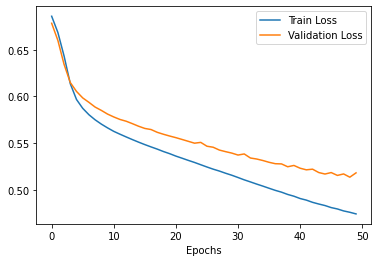

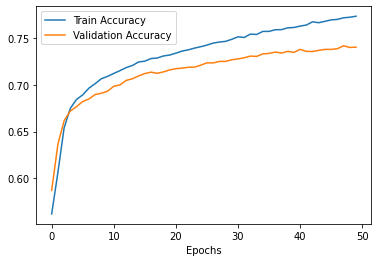

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1)
ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epochs')
plt.legend()
plt.show()

## Test our model

In [52]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "game of thrones season finale showing this sunday night"]

sequences = tokenizer.texts_to_sequences(test_sentences)
#print(sequences)
padded = pad_sequences(sequences, maxlen=max_len, padding='post')
#print(padded)

predictions = model.predict(padded)

#print(predictions[:, max_length-1])
print(predictions)

[[0.94373167]
 [0.5813857 ]
 [0.10161672]]


## Save embedding vectors to visualize in TensorFlow Projector

In [53]:
import io

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
e = model.layers[0]
weights = e.get_weights()[0]

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>